In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [2]:
#Load processed data
with open('/content/drive/MyDrive/body fat predictor/data/processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [3]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [4]:
#Train and evaluate each model
results=[]


for name, model in models.items():
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    results.append({
        'Model': name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Test RMSE': test_rmse,
        'Test MAE': test_mae,
        'CV R² Mean': cv_scores.mean(),
        'CV R² Std': cv_scores.std()
    })

    print(f"\n{name}:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE: {test_mae:.4f}")
    print(f"  CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Linear Regression:
  Train R²: 0.7277
  Test R²: 0.7349
  Test RMSE: 3.8206
  Test MAE: 3.0235
  CV R²: 0.6652 (+/- 0.0723)

Ridge:
  Train R²: 0.7258
  Test R²: 0.7391
  Test RMSE: 3.7903
  Test MAE: 3.0280
  CV R²: 0.6727 (+/- 0.0705)

Lasso:
  Train R²: 0.7187
  Test R²: 0.7390
  Test RMSE: 3.7911
  Test MAE: 3.1246
  CV R²: 0.6715 (+/- 0.0700)

Random Forest:
  Train R²: 0.9472
  Test R²: 0.7356
  Test RMSE: 3.8151
  Test MAE: 3.1368
  CV R²: 0.6150 (+/- 0.0643)

Gradient Boosting:
  Train R²: 0.9755
  Test R²: 0.6579
  Test RMSE: 4.3399
  Test MAE: 3.4954
  CV R²: 0.5855 (+/- 0.0560)


In [5]:
# Results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print(results_df.to_string(index=False))


            Model  Train R²  Test R²  Test RMSE  Test MAE  CV R² Mean  CV R² Std
Linear Regression  0.727663 0.734875   3.820638  3.023462    0.665239   0.072285
            Ridge  0.725841 0.739066   3.790325  3.027968    0.672716   0.070509
            Lasso  0.718724 0.738953   3.791138  3.124589    0.671452   0.069964
    Random Forest  0.947173 0.735638   3.815140  3.136837    0.614960   0.064284
Gradient Boosting  0.975535 0.657911   4.339903  3.495380    0.585468   0.056012


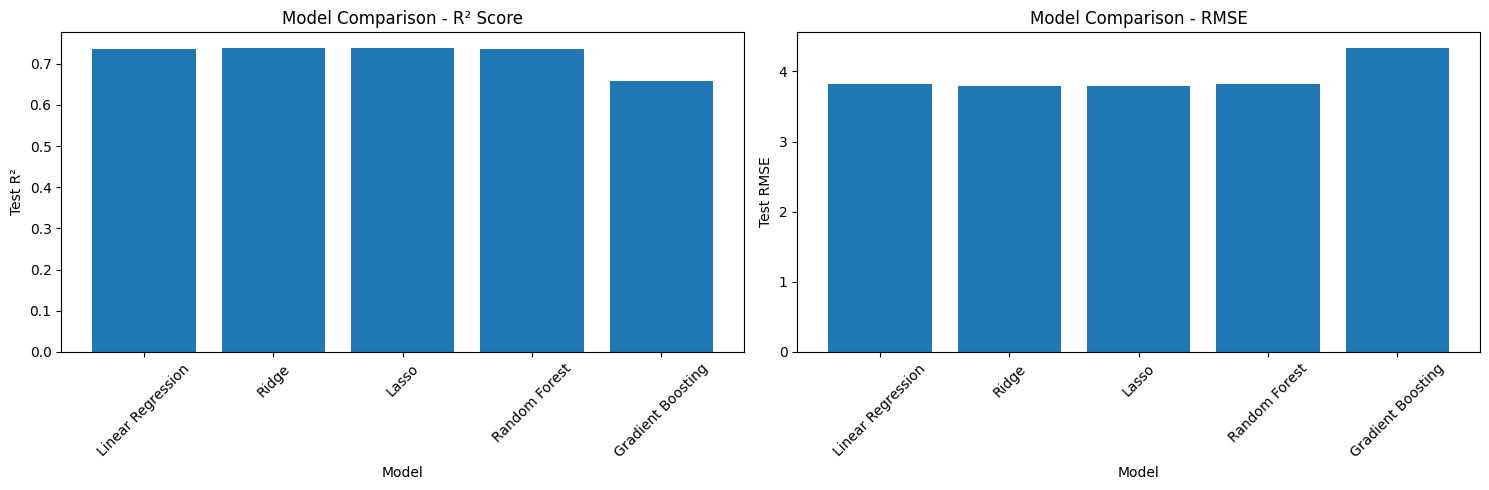

In [6]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² comparison
axes[0].bar(results_df['Model'], results_df['Test R²'])
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Test R²')
axes[0].set_title('Model Comparison - R² Score')
axes[0].tick_params(axis='x', rotation=45)

# RMSE comparison
axes[1].bar(results_df['Model'], results_df['Test RMSE'])
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Test RMSE')
axes[1].set_title('Model Comparison - RMSE')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# Select best model (likely Random Forest or Gradient Boosting)
best_model_name = results_df.loc[results_df['Test R²'].idxmax(), 'Model']
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")


Best Model: Ridge



Top 10 Most Important Features (by absolute coefficient):
                   Feature  Coefficient  Abs_Coefficient
1                   Weight    -2.597742         2.597742
15  Age_Weight_Interaction     2.411455         2.411455
14         Waist_Hip_Ratio     1.959275         1.959275
5                  Abdomen     1.758070         1.758070
12                   Wrist    -1.707801         1.707801
16     Chest_Abdomen_Ratio    -1.576712         1.576712
6                      Hip     1.519214         1.519214
13                     BMI     1.269375         1.269375
4                    Chest     1.172744         1.172744
0                      Age    -1.042287         1.042287


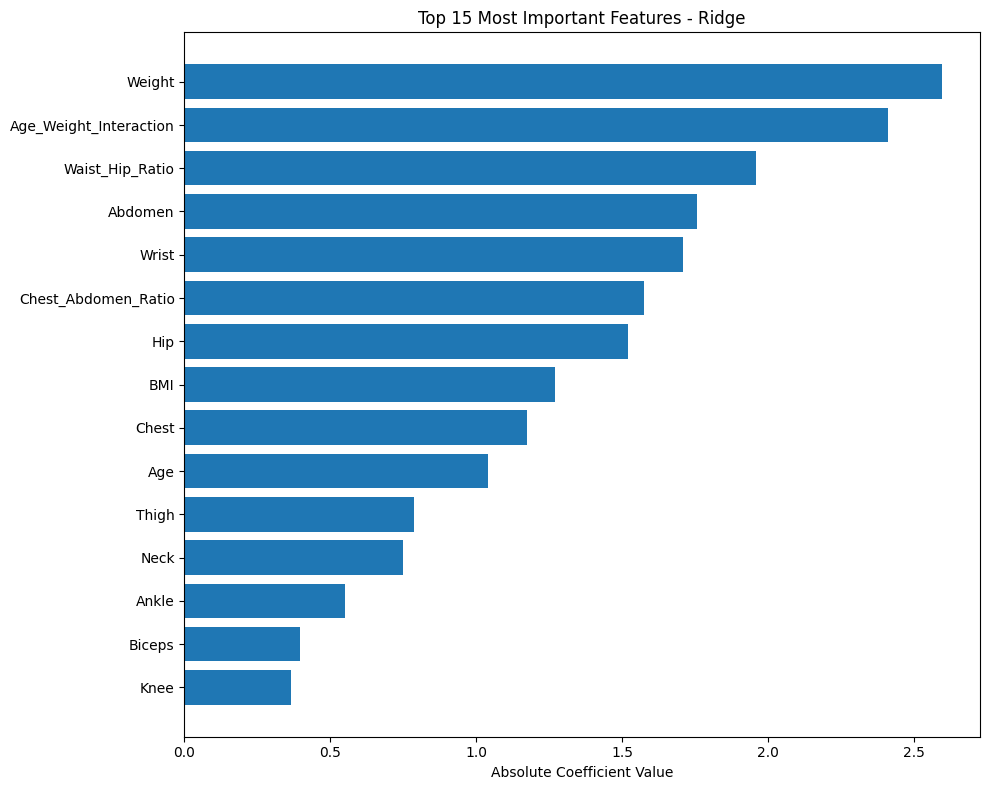

In [8]:
if hasattr(best_model, 'coef_'):
    # Get absolute coefficients (magnitude matters, not direction)
    feature_importance = pd.DataFrame({
        'Feature': data['feature_names'],
        'Coefficient': best_model.coef_,
        'Abs_Coefficient': np.abs(best_model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)

    print("\nTop 10 Most Important Features (by absolute coefficient):")
    print(feature_importance.head(10))

    # Plot top 15 features
    top_n = min(15, len(feature_importance))
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['Feature'].head(top_n),
             feature_importance['Abs_Coefficient'].head(top_n))
    plt.xlabel('Absolute Coefficient Value')
    plt.title(f'Top {top_n} Most Important Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

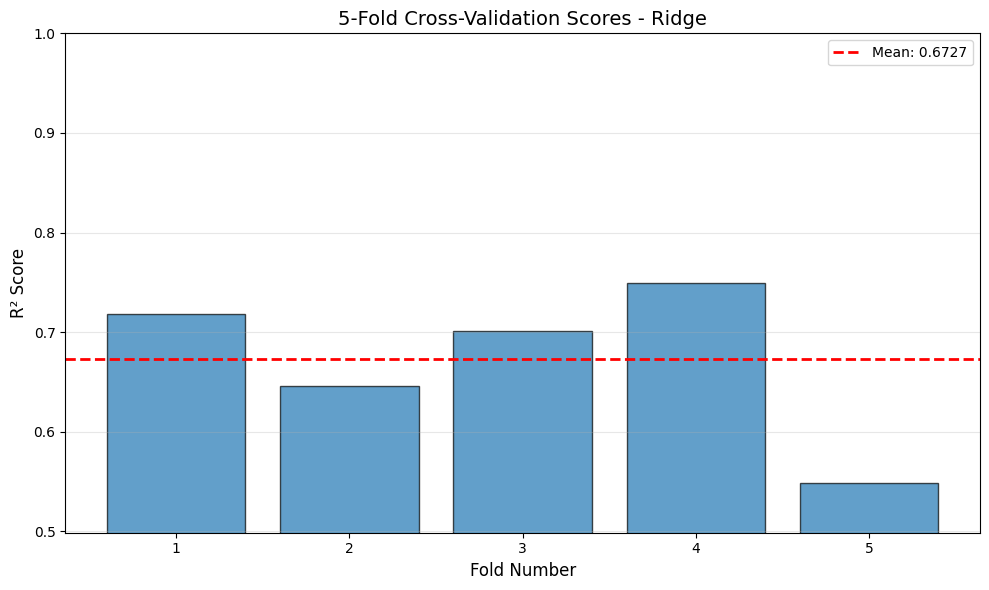

In [11]:
# Cross-Validation Scores Visualization
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')

plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, alpha=0.7, edgecolor='black')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', lw=2, label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title(f'5-Fold Cross-Validation Scores - {best_model_name}', fontsize=14)
plt.ylim([cv_scores.min() - 0.05, 1.0])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


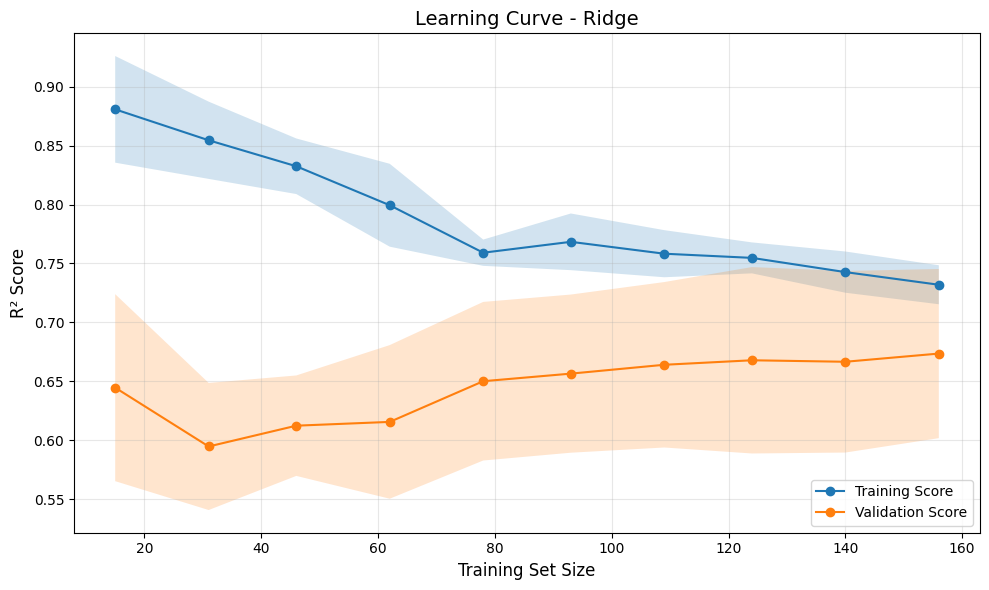

In [13]:
# Learning Curve (shows if model would benefit from more data)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='r2', n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation Score', marker='o')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title(f'Learning Curve - {best_model_name}', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [15]:
# Save Best Model
with open('/content/drive/MyDrive/body fat predictor/model/best_model.pkl', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'model_name': best_model_name,
        'scaler': data['scaler'],
        'feature_names': data['feature_names'],
        'metrics': results_df[results_df['Model'] == best_model_name].to_dict('records')[0],
        'feature_importance': feature_importance.to_dict('records')
    }, f)